In [4]:
import os
import pandas as pd
from tqdm import tqdm
import re
import langid 
import random
import numpy as np
import string
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

from functions import *

In [5]:
tf = pd.read_csv(base_path + '/resources/keywords-expertise-translation.csv')
tf_science = {language:dict(zip(tf[tf['language'] == language]['word'],tf[tf['language'] == language]['translation'])) for language in list(set(tf['language']))}
tf_science = {k:{x:i for x,i in v.items() if x not in ["policy","program","measures","knowledge","information"]} for k,v in tf_science.items()}
tf_science.update({"gb":{k:k for k,v in tf_science['nl'].items()}})

In [93]:
data = data_loader.period(language='nl',data_version="lemmatized",start_date="2020-01",end_date="2020-08")
data = data[data["text"].str.len() >= 500]
data['date'] = [utils.find_date(x) for x in data['id']]
data = data.dropna().reset_index(drop=True)
data['l'] = ["science" if any(n in t for n in tf_science['nl'].values()) == True else "other" for t in data['text']]

looking for data in  /media/ruben/Elements/ParlaMint/nl/nl-ana-txt/
found 423 files


In [94]:
data = data.sample(10000).reset_index(drop=True)

In [113]:
def sent_to_words(texts):
        for sentence in texts:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

def remove_stopwords(texts):
    # stop_words = stopwords.words('english') + "right hon honorable gentleman gentlemen hon. member".split(' ')
    stop_words = stopwords.words('dutch') + 'wij jij gaan zeggen doen lid stellen motie'.split(' ')
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def TopicTerms(lda_model,num_topics,topic):
    tm = dict(lda_model.show_topics(formatted=False,num_words=8,num_topics=num_topics))
    ttt = [i[0] for i in tm[int(topic)]]
    return " | ".join(ttt)

def make_bigrams(texts):
    bigram = gensim.models.Phrases(texts, min_count=5, threshold=100) # higher threshold fewer phrases.
    bigram_mod = gensim.models.phrases.Phraser(bigram)

    return [bigram_mod[doc] for doc in texts]

def dict_corpus(texts):
        # Create Dictionary
        id2word = corpora.Dictionary(texts)
        corpus = [id2word.doc2bow(text) for text in texts]
        return id2word,corpus

def lda(n_topics,id2word,corpus,texts):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,
                                               num_topics=n_topics,
                                               random_state=100,update_every=1,chunksize=100,
                                               passes=100,alpha='auto',
                                               per_word_topics=True)
    # Save top words
    top_words_per_topic = []
    for t in range(lda_model.num_topics):
        top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 15)])

    return lda_model, pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P'])

In [114]:
data = data[data['l'] == "science"].reset_index(drop=True)

In [115]:
texts = data['text']
texts = sent_to_words(texts)
texts = remove_stopwords(texts)
texts = make_bigrams(texts)

In [116]:
id2word,corpus = dict_corpus(texts)

In [117]:
model, dfr = lda(24,id2word,corpus,texts)

In [118]:
dr = [[v[1] for v in model.get_document_topics(x,minimum_probability=0.0)] for x in corpus]
dr = pd.DataFrame(dr)
dr['d'] = [x[:7] for x in data['date']]
dr = dr.groupby('d').sum().T

In [119]:
for c in dr.columns:
    dr[c] = dr[c] / dr[c].sum()

In [120]:
dr = dr.T.reset_index()

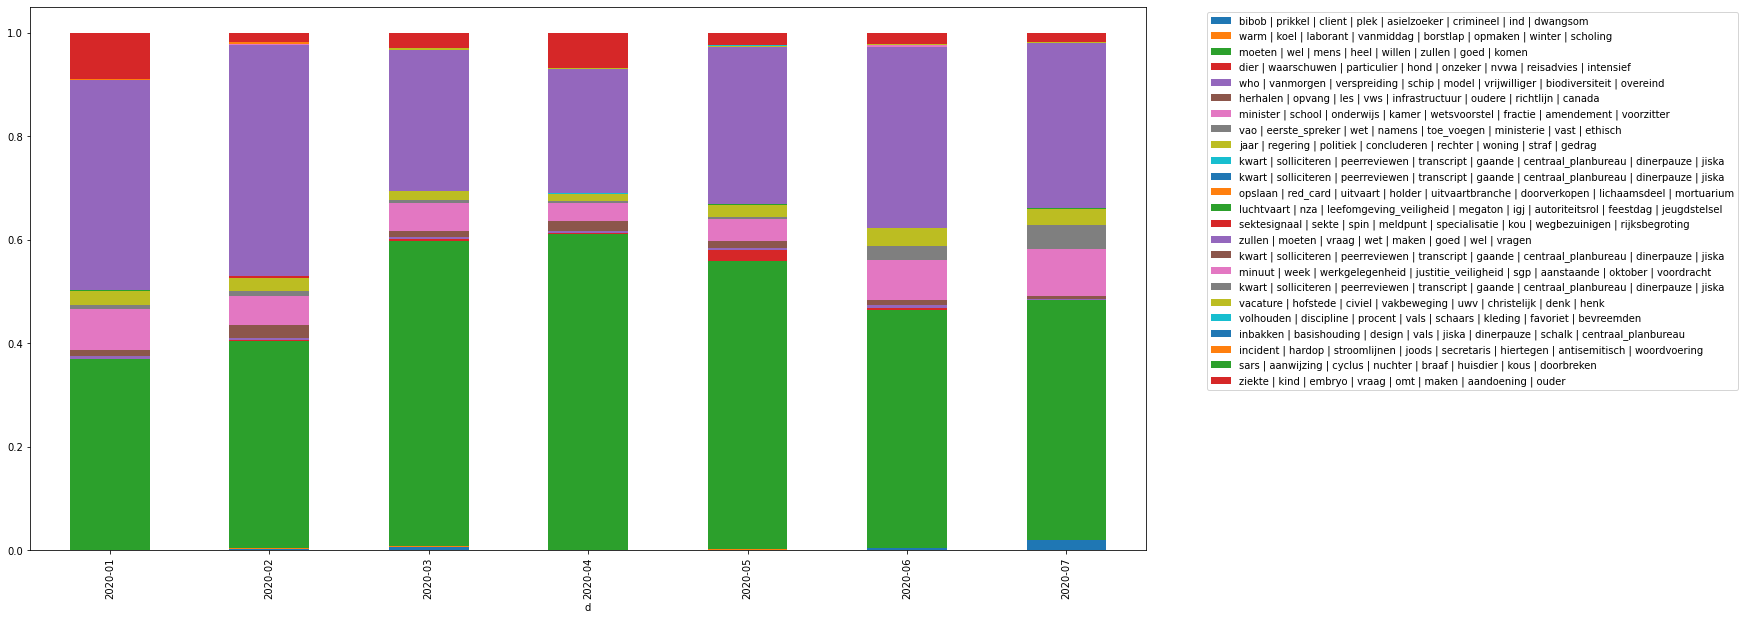

In [122]:
dr.plot.bar(stacked=True,x='d',y=list(dr.columns)[1:],figsize=(20,10))
plt.legend([TopicTerms(model,24,x) for x in list(dr.columns)[1:]],bbox_to_anchor=(1.05, 1), loc='upper left')